In [251]:
import pickle
import numpy as np
import matplotlib.pyplot as plot
from matplotlib import cm, rcParams
import tensorflow as tf

# Set up the colormap and default settings
cmap = cm.get_cmap('plasma')
rcParams.update({'font.size': 12})

# Load place cell and reward cell network data
with open('pcn.pkl', 'rb') as f:
    pc_net = pickle.load(f)
with open('rcn.pkl', 'rb') as f:
    rc_net = pickle.load(f)

# Load environment data (place cell and reward map coordinates)
with open('hmap_x.pkl', 'rb') as f:
    hmap_x = pickle.load(f)
with open('hmap_y.pkl', 'rb') as f:
    hmap_y = pickle.load(f)
with open('hmap_z.pkl', 'rb') as f:
    hmap_z = np.asarray(pickle.load(f))
with open('hmap_g.pkl', 'rb') as f:
    hmap_g = np.asarray(pickle.load(f))

goal_r = 0.3  # Define goal radius
goalLocation = [-1, 1]  # Define goal location (can be updated)

C:\Users\bduke\AppData\Local\Temp\ipykernel_23852\896432831.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')


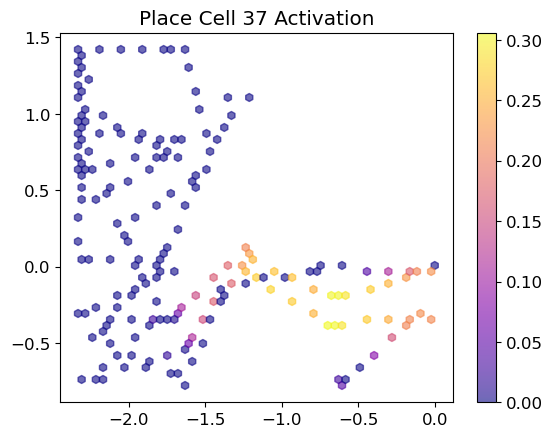

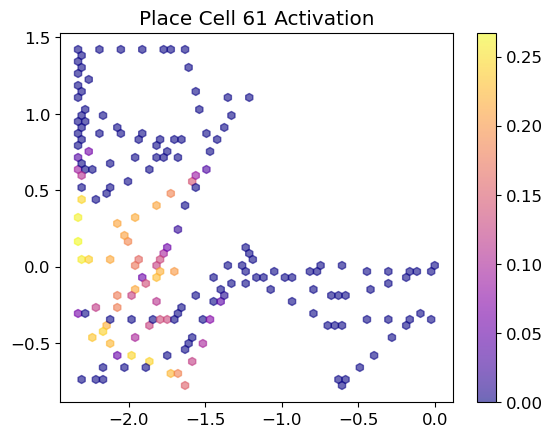

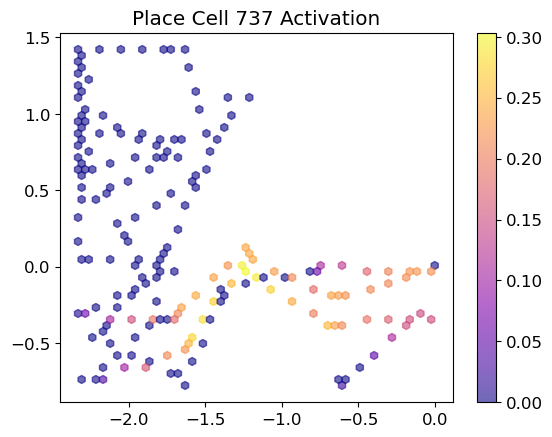

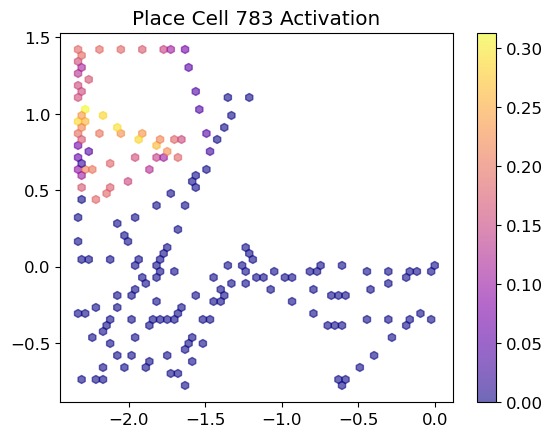

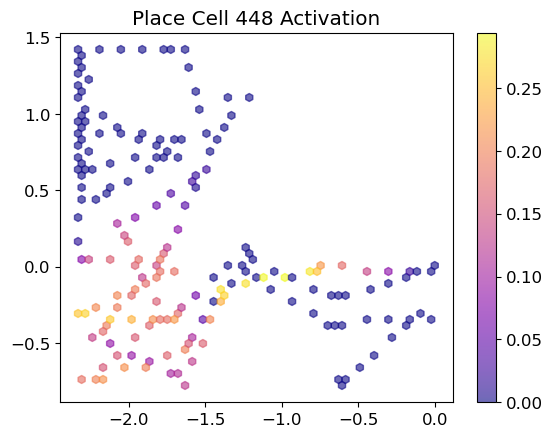

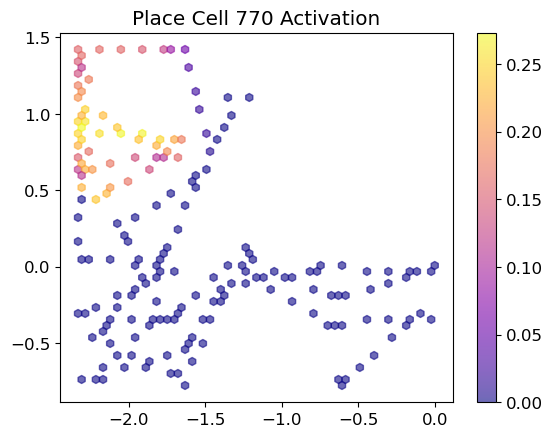

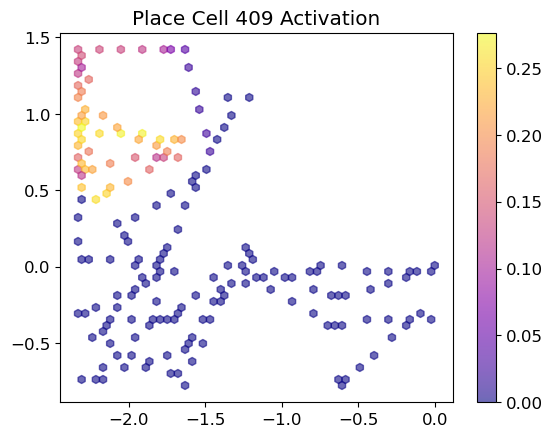

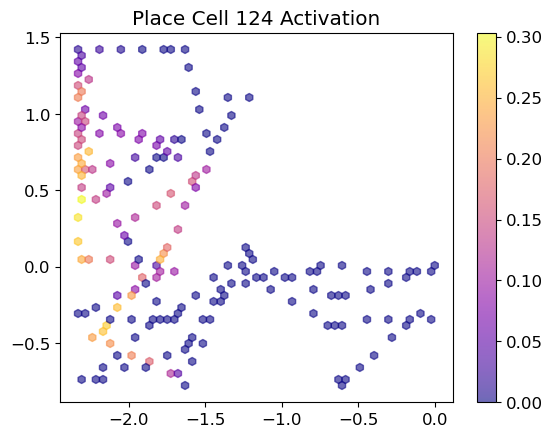

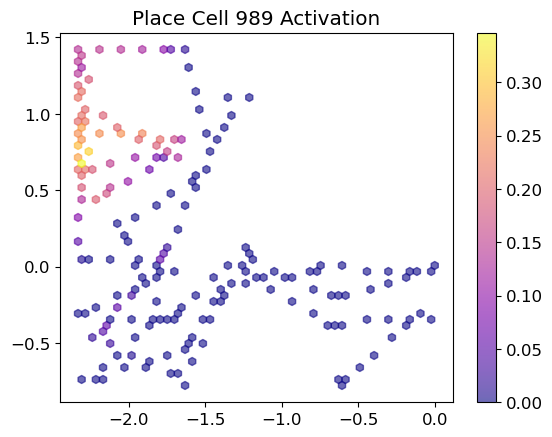

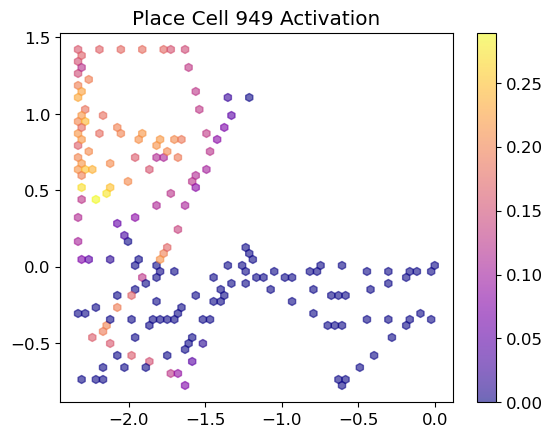

In [252]:
def probeOne(probed):
    """
    Visualizes the activation of a specific place cell (probed) over the environment map.
    """
    fig = plot.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    # Plot place cell activations using hexbin for better visualization
    cntr = ax.hexbin(hmap_x, hmap_y, hmap_z[:, probed].flatten(), gridsize=50, cmap=cmap, alpha=0.6)

    # Add colorbar and title
    plot.colorbar(cntr)
    v = f"v_{{{probed}}}^p"
    plot.title(f"Place Cell {probed} Activation")
    plot.show()

# Calculate the total activation for each place cell
total_activations = np.sum(hmap_z, axis=0)

# Get the indices of the top 10 most activated place cells
top_10_cells = np.argsort(total_activations)[-10:]

# Plot the activations for the top 10 place cells
for cell in top_10_cells:
    probeOne(cell)

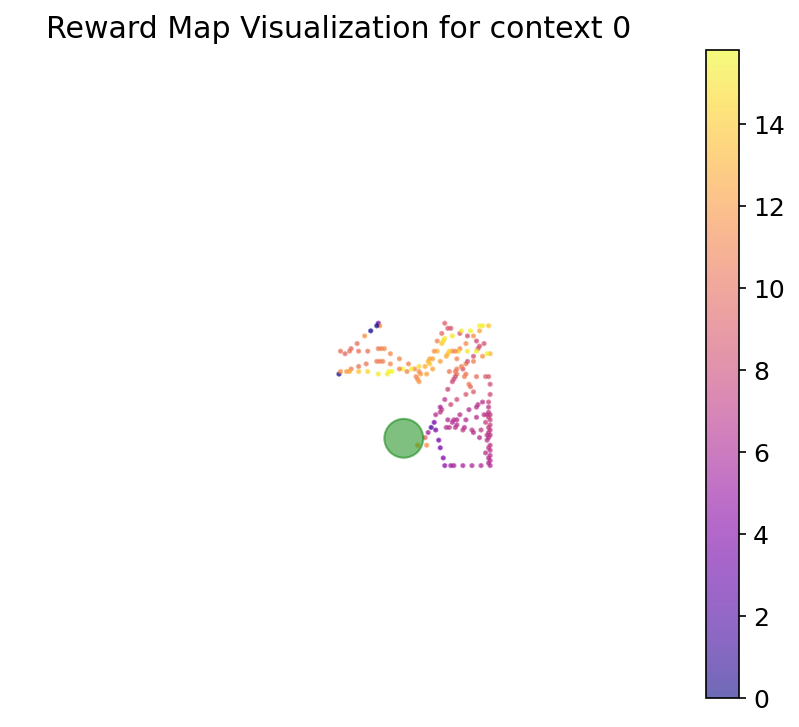

In [253]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

def plot_rcn_activation(context=0):
    """
    Visualizes the reward cell activations across the environment.

    Parameters:
    context (int): Context index for the reward cell weights.
    """
    # Load the RCN layer (reward cell network)
    with open('rcn.pkl', 'rb') as f:
        rc_net = pickle.load(f)

    # Compute the total place cell activations to use in normalizing the reward activations
    sum_activations = tf.reduce_sum(hmap_z, axis=-1)
    safe_denominator = tf.where(sum_activations > 0, sum_activations, 1)  # Avoid division by zero

    # Ensure that both tensors are float32 for tensordot and division
    hmap_z_float32 = tf.cast(hmap_z.T, tf.float32)  # Transpose and cast hmap_z to float32
    w_in_effective_float32 = tf.cast(rc_net.w_in_effective, tf.float32)  # Cast rc_net effective weights to float32
    safe_denominator = tf.cast(safe_denominator, tf.float32)  # Cast safe_denominator to float32

    # Compute the reward function using the RCN effective weights and the place cell activations
    reward_function = tf.tensordot(w_in_effective_float32[context], hmap_z_float32, axes=1) / safe_denominator

    # Flatten reward function to ensure it's a 1D array
    reward_function = tf.squeeze(reward_function)

    # Check if reward_function has the same shape as hmap_x and hmap_y
    if reward_function.shape != hmap_x.shape:
        raise ValueError(f"Shape mismatch: reward_function has shape {reward_function.shape}, but expected {hmap_x.shape}.")

    # Plot the reward function over the environment
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect('equal')

    # Create a hexbin plot for the reward activations
    cntr = ax.hexbin(hmap_x, hmap_y, reward_function.numpy(), gridsize=50, cmap=cmap, alpha=0.6)

    # Rotate the plot by 180 degrees by reversing the x and y limits
    ax.set_ylim(5, -5)
    ax.set_xlim(5, -5)
    ax.set_axis_off()

    # Increase the size of the map relative to the overall plot
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # Draw the goal location as a green circle
    goal = plt.Circle(goalLocation, goal_r, color='green', alpha=0.5, fill=True)
    ax.add_patch(goal)

    # Add a colorbar for the reward values
    fig.colorbar(cntr)
    plt.title(f"Reward Map Visualization for context {context}")
    plt.show()

# Call the function with a specific context
plot_rcn_activation(context=0)


In [254]:
top_40_values = np.sort(rc_net.w_in_effective, axis=None)[-40:]
print(top_40_values)

[ 4.9478483  4.949582   5.053147   5.1927085  5.243888   5.2790217
  5.3758283  5.5629106  5.868557   6.190611   6.682854   6.7556386
  6.839167   7.326552   7.8541546  7.9563904  8.237173   8.318061
  8.558673   8.869198   9.3384075  9.449179   9.903341  10.000376
 10.059053  10.665854  11.011469  11.365303  11.482655  11.766836
 11.772343  11.973651  12.571096  13.290087  13.486359  14.01337
 14.155986  14.5641775 14.577279  17.297054 ]
